In [1]:
import pandas as pd
import random
from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch

# Zero, One and Few Shots Learning

## Loading the LLM
We are gonna try the Zero, One and Few Shots Learning on the Google FLAN T5 Large

In [2]:
from transformers import T5Tokenizer, T5ForConditionalGeneration


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

t5_id = "google/flan-t5-large"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_id)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_id, torch_dtype=torch.bfloat16)

device = "cuda" if torch.cuda.is_available() else "cpu"
t5_model = t5_model.to(device)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## Loading the Dataset

In [3]:
dataset = load_dataset('derek-thomas/ScienceQA')

In [4]:
print(f"No. of documents: {len(dataset['train'])}")
print(f"No. of documents: {len(dataset['validation'])}")
print(f"No. of documents: {len(dataset['test'])}")

example = dataset['train'][0]
print(example)

No. of documents: 12726
No. of documents: 4241
No. of documents: 4241
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=750x429 at 0x14FD4D469F0>, 'question': 'Which of these states is farthest north?', 'choices': ['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma'], 'answer': 0, 'hint': '', 'task': 'closed choice', 'grade': 'grade2', 'subject': 'social science', 'topic': 'geography', 'category': 'Geography', 'skill': 'Read a map: cardinal directions', 'lecture': 'Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.\nA compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.\nThe north arrow points to the North Pole. On most maps, north is at the top of the map.', 'solution': 'To find the answer, look at the compass rose. Look at which way the north arrow is pointing. West Virginia is farthest north.'}


In [5]:
data = dataset["train"]

In [6]:
topics = set(data.unique("topic"))
print("Nombre de labels:", len(topics))
print("Exemples de labels:", list(topics))

Nombre de labels: 26
Exemples de labels: ['literacy-in-science', 'us-history', 'vocabulary', 'capitalization', 'punctuation', 'writing-strategies', 'culture', 'geography', 'grammar', 'verbs', 'civics', 'word-study', 'biology', 'figurative-language', 'chemistry', 'phonological-awareness', 'reading-comprehension', 'pronouns', 'global-studies', 'reference-skills', 'physics', 'science-and-engineering-practices', 'earth-science', 'world-history', 'economics', 'units-and-measurement']


### Formatting the dataset
Here, we format the dataset keeping only the ‘Lecture’, ‘Hint’ and ‘Solution’ fields.

In [7]:
def format_example(example):
    return {
        "input_text": f" Lecture:{example['lecture']}\nHint: {example['hint']}\nSolution: {example['solution']}",
        "label": example["topic"]
    }

formatted_data = [format_example(example) for example in data if example["lecture"] and example["hint"]]
formatted_data[0]

{'input_text': " Lecture:Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.\nImagine an experiment with two groups of daffodil plants. One group of plants was grown in sandy soil, and the other was grown in clay soil. Then, the height of each plant was measured.\nFirst, identify the part of the experiment that was tested. The part of an experiment that is tested usually involves the part of the experimental setup that is different or changed. In the experiment described above, each group of plants was grown in a different type of soil. So, the effect of growing plants in different soil types was tested.\nThen, identify the part of the experiment that was measured. The part of the experiment that is measured may include measurements and calculations. In the experiment described above, the heights of the p

## Zero shot
Let's start with the zero shot, which consists simply of asking the model to take its time and think when it produces its output.

The prompt given to models is the following :


*Let's think step-by-step to determine the topic.*
*Available topics: vocabulary, punctuation, physics, earth-science, literacy-in-science, culture, verbs, reference-skills, chemistry, biology, pronouns, capitalization, us-history, word-study, writing-strategies, economics, figurative-language, reading-comprehension, phonological-awareness, units-and-measurement, science-and-engineering-practices, global-studies, geography, world-history, civics, grammar*

*Given the following text, identify the most appropriate topic from the list above.*

*Text:*
*" Lecture:The temperature of a substance depends on the average kinetic energy of the particles in the substance. The higher the average kinetic energy of the particles, the higher the temperature of the substance.*
*The kinetic energy of a particle is determined by its mass and speed. For a pure substance, the greater the mass of each particle in the substance and the higher the average speed of the particles, the higher their average kinetic energy.*
*Hint: The diagrams below show two pure samples of gas in identical closed, rigid containers. Each colored ball represents one gas particle. Both samples have the same number of particles.*
*Solution: The particles in both samples have the same average speed, but each particle in sample B has more mass than each particle in sample A. So, the particles in sample B have a higher average kinetic energy than the particles in sample A.*
*Because the particles in sample B have the higher average kinetic energy, sample B must have the higher temperature."

*Reasoning:*


In [8]:
def predict_zero_shot(input_text, tokenizer, model, topics):
    prompt = (
        "Let's think step-by-step to determine the topic.\n"
        f"Available topics: {', '.join(topics)}\n\n"
        "Given the following text, identify the most appropriate topic from the list above.\n\n"
        f"Text:\n\"{input_text}\"\n\n"
        "Reasoning:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=30)  # 30 tokens to allow reasoning + answer
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True).lower().strip()
    return prediction

Here is some example with the T5 FLAN model :

In [10]:
i=0
for a in range(5):
    pred = predict_zero_shot(formatted_data[a]["input_text"],t5_tokenizer,t5_model,topics)
    print(f"prediction",i)
    print(pred)
    print(formatted_data[a]["label"])
    i+=1

prediction 0
physics
science-and-engineering-practices
prediction 1
figurative-language
science-and-engineering-practices
prediction 2
biology
biology
prediction 3
physics
physics
prediction 4
biology
biology


In [14]:
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm

Let's create a function to run multiple time the *predict_zero_shot* function and compute accuracy

In [12]:
def predict_many_zero_shots(tokenizer, model, topics,formatted_data, number=1):
    predictions = []
    ground_truths = []
    sampled_data = random.sample(formatted_data, number)

    for example in tqdm(sampled_data, desc="Predicting topics"):
        

        pred = predict_zero_shot(example["input_text"], tokenizer, model, topics)

        pred_clean = next((t for t in topics if t in pred), "unknown")

        predictions.append(pred_clean.lower().strip())
        ground_truths.append(example["label"].lower().strip())

    return predictions, ground_truths
    
    

Accuracy of T5 FLAN model :

In [13]:
preds, trues = predict_many_zero_shots(t5_tokenizer, t5_model, topics, formatted_data, number=50)

acc_zero_t5 = accuracy_score(trues, preds)
print(f"\nAccuracy (zero-shot, {len(preds)} exemples) : {acc_zero_t5*100:.2f}%")

Predicting topics: 100%|██████████| 50/50 [10:20<00:00, 12.41s/it]


Accuracy (zero-shot, 50 exemples) : 90.00%


## One and Few Shots
The One or Few Shots Learning consist to add one or few exemple in the promt to better guide the LLM in the task he is assign to.

Here is an example of a few shot learning prompt with 2 examples :

*You are an expert at classifying text into specific topics. The available topics are: pronouns, figurative-language, verbs, us-history, phonological-awareness, global-studies, earth-science, grammar, civics, reading-comprehension, units-and-measurement, vocabulary, writing-strategies, economics, capitalization, world-history, biology, culture, science-and-engineering-practices, literacy-in-science, physics, reference-skills, geography, chemistry, punctuation, word-study.*

*Your task is to read the input text, think through the content step by step, and determine the most appropriate topic from the list.*

*Here are some examples:*

*### Example 1 ###*

*Text: " Lecture:Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.*
*Imagine an exp..."*

*Reasoning: Let's analyze the key themes and ideas. Based on the vocabulary and context, we identify the main subject. Hence, the most relevant topic is science-and-engineering-practices.*

*Answer: science-and-engineering-practices*


*### Example 2 ###*

*Text: " Lecture:A food web is a model.*
*A food web shows where organisms in an ecosystem get their food. Models can make things in nature easier to understand because models can represent complex things in a simpler way. If a food web showed every organism in an ecos..."*

*Reasoning: Let's analyze the key themes and ideas. Based on the vocabulary and context, we identify the main subject. Hence, the most relevant topic is biology.*

*Answer: biology*


*### New Example ###*

*Text: " Lecture:Scientists sort animals with similar traits into groups. This is called classification. Classification helps scientists learn about how animals live.*
*How do scientists classify animals? First, they make observations about an animal. Scientists observe the animal's traits, including its body parts and behavior. Then, scientists compare the animal's traits to other animals' traits. Scientists classify animals with similar traits into a group.*
*Hint: Reptiles are a group of animals with similar traits. The following traits can be used to identify reptiles:*
*They have scaly, waterproof skin.*
*They make eggs with shells. Observe the animals and read the descriptions.*
*Solution: To decide if an animal is part of a group, look at the traits of the group.*
*...*
*It has scaly, waterproof skin.*
*It makes eggs with shells.*
*A box turtle has the traits of a reptile. A box turtle is a reptile."*

*Reasoning: Let's analyze the key themes and ideas.*


We found that the prompt quickly became very, very large as the number of n_shots increased. The precision obtained for n_shots greater than 1 fell to around 20% (see just below). To counter this problem, we decided to truncate the examples by limiting them to 250 characters (see part **One and Few Shots with shorter example** below). In this way, the precision rose for n_shots greater or equal to 1.

The prompt displayed above corresponds to the prompts with the truncated examples.

In [8]:
def predict_one_or_few_shots(input_text, tokenizer, model, topics,example_data,n_shots = 1):
    prompt = (
        "You are an expert at classifying text into specific topics. "
        f"The available topics are: {', '.join(topics)}.\n\n"
        "Your task is to read the input text, think through the content step by step, "
        "and determine the most appropriate topic from the list.\n\n"
        "Here are some examples:\n\n"
    )

    for i, ex in enumerate(example_data[:n_shots]):
        ex_text = ex["input_text"]
        ex_label = ex["label"]

        prompt += (
            f"### Example {i+1} ###\n"
            f"Text: \"{ex_text}\"\n"
            "Reasoning: Let's analyze the key themes and ideas. "
            "Based on the vocabulary and context, we identify the main subject. "
            f"Hence, the most relevant topic is {ex_label}.\n"
            f"Answer: {ex_label}\n\n"
        )

    prompt += (
        "### New Example ###\n"
        f"Text: \"{input_text}\"\n"
        "Reasoning: Let's analyze the key themes and ideas. "
    )
    #print(prompt)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(**inputs, max_new_tokens=50)  
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True).lower().strip()
    return prediction

Here is a function to execute many few shots learning many times.

In [15]:
def predict_many_one_or_few_shots(tokenizer, model, topics,formatted_data, number=1,n_shots = 1):
    predictions = []
    ground_truths = []
    sampled_data = random.sample(formatted_data, number)

    for example in tqdm(sampled_data, desc="Predicting topics"):
        
        sampled = random.sample(formatted_data, n_shots + 1)
        example_data = sampled[:n_shots]
        test_example = sampled[-1]

        input_text = test_example["input_text"]
        true_label = test_example["label"]

        pred = predict_one_or_few_shots(input_text, tokenizer, model, topics, example_data, n_shots=n_shots)
        pred_clean = next((t for t in topics if t in pred), "unknown")

        predictions.append(pred_clean.lower().strip())
        ground_truths.append(true_label.lower().strip())

    return predictions, ground_truths

Here is the function to compute the accuracy of the Few Shot Learning :

In [9]:
import matplotlib.pyplot as plt

In [18]:
def evaluate_few_shot_accuracy(tokenizer, model, topics, formatted_data, max_shots=5, n_tests=50):
    shot_values = list(range(1, max_shots + 1))
    accuracies = []

    for n_shots in shot_values:
        print(f"Testing with {n_shots} shot(s)...")
        preds, labels = predict_many_one_or_few_shots(
            tokenizer=tokenizer,
            model=model,
            topics=topics,
            formatted_data=formatted_data,
            number=n_tests,
            n_shots=n_shots
        )

        acc = accuracy_score(labels, preds)
        accuracies.append(acc)

    return shot_values, accuracies

In [19]:
shot_vals, acc_vals = evaluate_few_shot_accuracy(
    tokenizer=t5_tokenizer,
    model=t5_model,
    topics=topics,
    formatted_data=formatted_data,
    max_shots=5,      
    n_tests=50
)

Testing with 1 shot(s)...


Predicting topics: 100%|██████████| 50/50 [13:58<00:00, 16.77s/it]


Testing with 2 shot(s)...


Predicting topics: 100%|██████████| 50/50 [13:54<00:00, 16.69s/it]


Testing with 3 shot(s)...


Predicting topics: 100%|██████████| 50/50 [18:23<00:00, 22.07s/it]


Testing with 4 shot(s)...


Predicting topics: 100%|██████████| 50/50 [19:59<00:00, 23.98s/it]


Testing with 5 shot(s)...


Predicting topics: 100%|██████████| 50/50 [17:27<00:00, 20.96s/it]


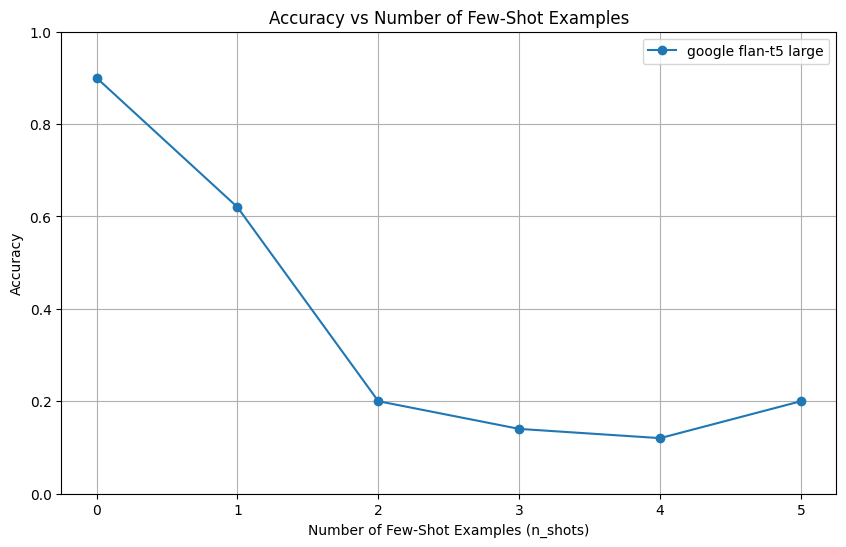

In [20]:
all_shots = [0] + shot_vals
accs_model1_full = [acc_zero_t5] + acc_vals

plt.figure(figsize=(10, 6))
plt.plot(all_shots, accs_model1_full, marker='o', label="google flan-t5 large")

plt.title("Accuracy vs Number of Few-Shot Examples")
plt.xlabel("Number of Few-Shot Examples (n_shots)")
plt.ylabel("Accuracy")
plt.xticks(all_shots)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()

One shot learning is only around 60% of accuracy, and when the number of shots is even greater the accuracy is around 20 percent. So now, let's try with a shorter promt.

## One and Few Shots with shorter example
As explained before, in this part we truncated the example in order to have smaller promt for the LLM to perform better. The example are truncated to 250 caracters and we add "..." at the end of the example.

In [10]:
def format_short_example(example):
    lecture = example['lecture']
    short_lecture = lecture[:250] + "..." if len(lecture) > 253 else lecture
    return {
        "input_text": f" Lecture:{short_lecture}",
        "label": example["topic"]
    }

short_formatted_data = [format_short_example(example) for example in data if example["lecture"] and example["hint"]]
short_formatted_data[0]

{'input_text': ' Lecture:Experiments can be designed to answer specific questions. How can you identify the questions that a certain experiment can answer? In order to do this, you need to figure out what was tested and what was measured during the experiment.\nImagine an exp...',
 'label': 'science-and-engineering-practices'}

In [11]:
def new_predict_many_one_or_few_shots(tokenizer, model, topics,input_data,example_data, number=1,n_shots = 1):
    predictions = []
    ground_truths = []
    sampled_data = random.sample(input_data, number)

    for example in tqdm(sampled_data, desc="Predicting topics"):
        few_shot_example = random.sample(example_data, n_shots)

        input_text = example["input_text"]
        true_label = example["label"]

        pred = predict_one_or_few_shots(input_text, tokenizer, model, topics, few_shot_example, n_shots=n_shots)
        pred_clean = next((t for t in topics if t in pred), "unknown")

        predictions.append(pred_clean.lower().strip())
        ground_truths.append(true_label.lower().strip())

    return predictions, ground_truths

In [12]:
def new_evaluate_few_shot_accuracy(tokenizer, model, topics,input_data, example_data, max_shots=5, n_tests=50):
    shot_values = list(range(1, max_shots + 1))
    accuracies = []

    for n_shots in shot_values:
        print(f"Testing with {n_shots} shot(s)...")
        preds, labels = new_predict_many_one_or_few_shots(
            tokenizer=tokenizer,
            model=model,
            topics=topics,
            input_data=input_data,
            example_data=example_data,
            number=n_tests,
            n_shots=n_shots
        )

        acc = accuracy_score(labels, preds)
        accuracies.append(acc)

    return shot_values, accuracies

In [16]:
new_shot_vals, new_acc_vals = new_evaluate_few_shot_accuracy(
    tokenizer=t5_tokenizer,
    model=t5_model,
    topics=topics,
    input_data=formatted_data,
    example_data=short_formatted_data,
    max_shots=5,      
    n_tests=50
)

Testing with 1 shot(s)...


Predicting topics: 100%|██████████| 50/50 [14:31<00:00, 17.42s/it]


Testing with 2 shot(s)...


Predicting topics: 100%|██████████| 50/50 [15:19<00:00, 18.39s/it]


Testing with 3 shot(s)...


Predicting topics: 100%|██████████| 50/50 [15:36<00:00, 18.72s/it]


Testing with 4 shot(s)...


Predicting topics: 100%|██████████| 50/50 [15:09<00:00, 18.20s/it]


Testing with 5 shot(s)...


Predicting topics: 100%|██████████| 50/50 [14:39<00:00, 17.58s/it]


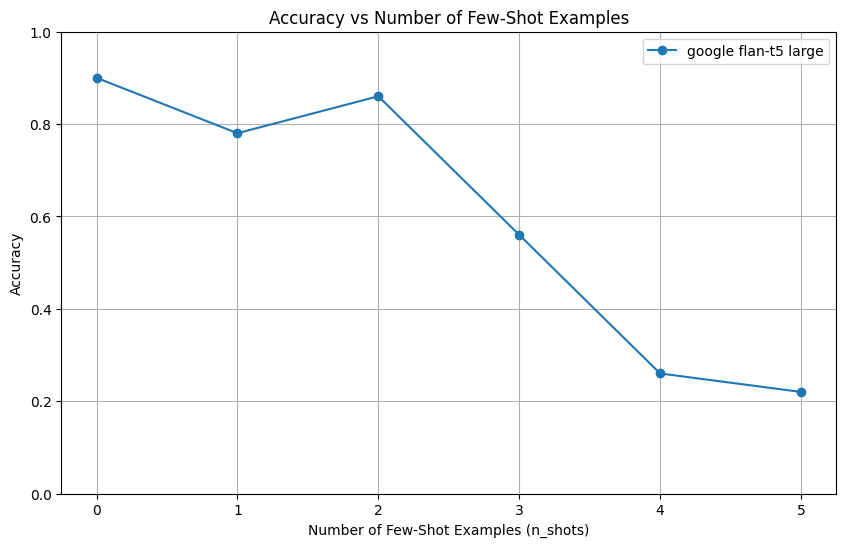

In [19]:
acc_zero_t5=0.9 #from above
new_all_shots = [0] + new_shot_vals
new_accs_model1_full = [acc_zero_t5] + new_acc_vals

plt.figure(figsize=(10, 6))
plt.plot(new_all_shots, new_accs_model1_full, marker='o', label="google flan-t5 large")

plt.title("Accuracy vs Number of Few-Shot Examples")
plt.xlabel("Number of Few-Shot Examples (n_shots)")
plt.ylabel("Accuracy")
plt.xticks(new_all_shots)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend()
plt.show()

This is our final result about Zero, One and Few shots learning. The zero shot learning is performing well (90 % of accuracy). One and two shots learning are achieving the same level of accuracy as the zero shot learning. 

But when the number of shot is growing the accuracy of the prediction start to decrease up to 20% for n_shots = 5. The promt probably becomes too large from n_shots = 3 for the capacity of the LLM used, which could explain the drop in accuracy.
